#  Adagrad optimizer

Adagrad (Adaptive Gradient Algorithm) is an optimization algorithm commonly used in training artificial neural networks (ANNs). It dynamically adjusts the learning rates of each parameter based on the historical gradients. 

## Details of Adagrad Algorithm

Adagrad is designed to adaptively adjust the learning rates for each parameter during training. It achieves this by scaling the learning rates based on the historical gradients of each parameter. Here's how Adagrad works:

1. Compute Squared Gradients: Adagrad maintains a sum of the squared gradients for each parameter.

2. Adapt Learning Rates: It divides the learning rate by the square root of the sum of squared gradients for each parameter. This effectively reduces the learning rate for parameters that have large gradients and increases it for parameters that have small gradients.

3. Accumulation of Gradients: Adagrad accumulates the squared gradients over time, so the learning rates decrease monotonically during training.

## Pros of Adagrad optimizer

1. Adaptive Learning Rates: Adagrad adapts the learning rates for each parameter individually based on the historical gradients. This can help converge faster and more efficiently, especially for sparse data or when dealing with features that occur infrequently.

2. No Manual Tuning of Learning Rate: Adagrad automatically adjusts the learning rates based on the gradients, reducing the need for manual tuning of learning rate hyperparameters.

## Cons of Adagrad optimizer

1. Decreasing Learning Rates: Adagrad's accumulation of squared gradients can lead to learning rates that decrease too aggressively over time. This can cause the learning process to slow down prematurely, especially for deep neural networks.

2. Memory Usage: Adagrad needs to store and update the sum of squared gradients for each parameter, which can lead to increased memory usage, especially for models with many parameters.

3. RMSprop and AdaDelta: While Adagrad was one of the early adaptive learning rate algorithms, more recent algorithms like RMSprop and AdaDelta have been developed to address some of its shortcomings, such as the aggressive decrease in learning rates.

In [1]:
from fashionmnist_model import FMM
import tensorflow as tf

In [2]:
# Load and preprocess the data
X_train, y_train, X_test, y_test = FMM.load_data()

In [3]:
# Reshape the data
X_train, X_test = FMM.reshape_data(X_train, X_test)

In [4]:
optimizer = tf.keras.optimizers.Adagrad()
model = FMM.create_model_v2()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with Adagrad optimizer...


2024-02-22 11:13:45.442472: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30
480/480 [==============================] - 2s 2ms/step - loss: 1.6747 - accuracy: 0.4310 - val_loss: 1.0223 - val_accuracy: 0.7070
Epoch 2/30
480/480 [==============================] - 1s 2ms/step - loss: 1.2400 - accuracy: 0.5900 - val_loss: 0.8338 - val_accuracy: 0.7593
Epoch 3/30
480/480 [==============================] - 1s 2ms/step - loss: 1.1080 - accuracy: 0.6403 - val_loss: 0.7672 - val_accuracy: 0.7749
Epoch 4/30
480/480 [==============================] - 1s 2ms/step - loss: 1.0256 - accuracy: 0.6676 - val_loss: 0.7204 - val_accuracy: 0.7856
Epoch 5/30
480/480 [==============================] - 1s 2ms/step - loss: 0.9755 - accuracy: 0.6853 - val_loss: 0.6851 - val_accuracy: 0.7922
Epoch 6/30
480/480 [==============================] - 1s 3ms/step - loss: 0.9339 - accuracy: 0.7002 - val_loss: 0.6573 - val_accuracy: 0.7992
Epoch 7/30
480/480 [==============================] - 1s 2ms/step - loss: 0.9009 - accuracy: 0.7067 - val_loss: 0.6326 - val_accuracy: 0.8030
Epoch 

313/313 - 0s - loss: 0.5031 - accuracy: 0.8228 - 299ms/epoch - 955us/step

Training accuracy : 0.7846875190734863
Validation accuracy : 0.8354166746139526
Loss : 0.5031096935272217
Accuracy : 0.8227999806404114



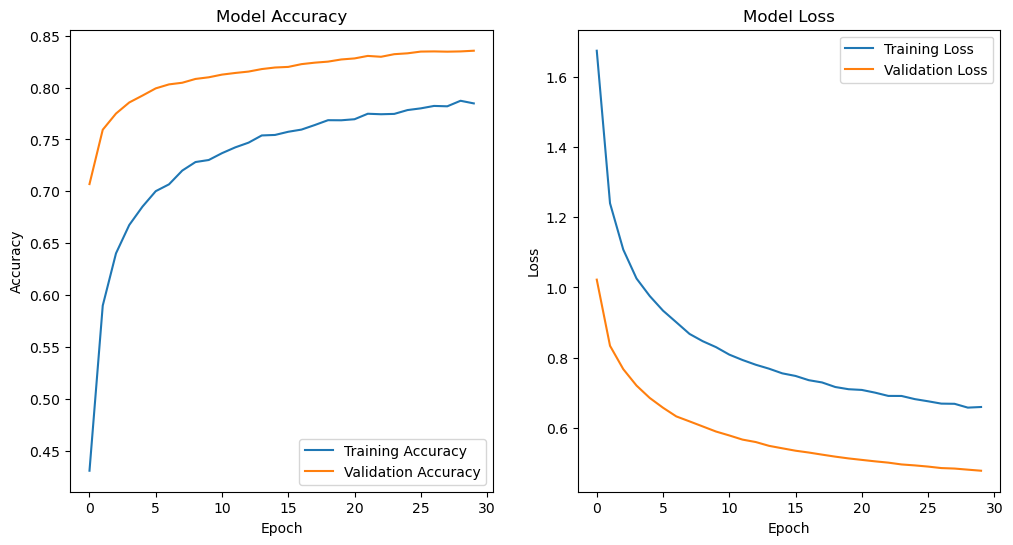

In [5]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)

# Hyperparameter tunning

In [ ]:
# Hyperparameter tunning

In [ ]:
import ray
from ray import tune, train

In [ ]:
ray.init()

In [ ]:
# Define a function to train the model
def train_model(config):
    from fashionmnist_model import FMM
    import tensorflow as tf
    
    X_train, y_train, X_test, y_test = FMM.load_data()
    X_train, X_test = FMM.reshape_data(X_train, X_test)

    optimizer = tf.keras.optimizers.legacy.Adagrad(
        learning_rate=config["learning_rate"],
        epsilon=config["epsilon"],
    )

    model = FMM.create_model_v2()
    history = FMM.compile_and_train(
        model, X_train, y_train, optimizer
    )
    
    loss, accuracy, _, _ = FMM.evaluate(model, X_test, y_test, history)

    train.report({"accuracy": accuracy, "loss": loss, **config})

In [ ]:
search_space = {
    "learning_rate": tune.grid_search([0.01, 0.001, 0.0001]),
    "epsilon": tune.grid_search([1e-8, 1e-9, 1e-10]),
}

In [ ]:
# Run hyperparameter tuning
analysis = tune.run(
    train_model,
    config=search_space,
    metric="accuracy",
    mode="max",
)

In [ ]:
ray.shutdown()

In [ ]:
FMM.plot_analysis_results(analysis, x_axis="learning_rate", y_axis="accuracy")

In [ ]:
# Print the best hyperparameters and results
best_config = analysis.best_config
print("Best hyperparameters:", best_config)
print("Best accuracy:", analysis.best_result["accuracy"])